# Plot distributions of contact distance

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import anndata
import matplotlib.pyplot as plt
from matplotlib import ticker

In [2]:
pd.options.mode.copy_on_write = True

In [3]:
root = Path("/tscc/projects/ps-epigen/users/biy022/scmethylhic/human_hippocampus/snm3c/")
hic_path = root / "Combined" / "hic"
contact_table_path = hic_path / "contact_tables"

## Aggregate names of contact files for each subclass x donor for easier manipulation

In [3]:
# Load meta file
meta_file = "/tscc/projects/ps-renlab2/sel041/scmethylhic/human_hippocampus/concat/human_aging_final_metadata.csv.gz"

In [4]:
meta_df = pd.read_csv(meta_file, header=0, index_col=1)

In [5]:
meta_df.drop(meta_df.columns[0], axis=1, inplace=True)

In [6]:
## First, subset based on final_celltype x donor (no Inh and Exc neurons)
meta_df["final_celltype_donor"] = meta_df.apply(lambda x: "-".join([x["final_celltype"], x["donor"]]), axis=1)
meta_df["final_celltype2_donor"] = meta_df.apply(lambda x: "-".join([x["final_celltype2"], x["donor"]]), axis=1)

In [7]:
all_names = []
for subclass_donor, sub_df in meta_df.groupby("final_celltype_donor"):
    subclass, donor = subclass_donor.rsplit("-", 1)
    all_names.append((subclass, subclass_donor))

    if not (contact_table_path / subclass).exists():
        (contact_table_path / subclass).mkdir(parents=True, exist_ok=True)

    sub_df["contact_files"] = sub_df.apply(
        lambda x: root / (x["sample"] + "_deep") / "hic" / "rmbkl" / (x.name + ".contact.rmbkl.tsv.gz"), axis=1)
    sub_df["contact_files"].to_csv(
        contact_table_path / subclass / f"{subclass}-{donor}.tsv",
        sep="\t",
        header=False,
        index=True
    )

for subclass_donor, sub_df in meta_df.groupby("final_celltype2_donor"):
    subclass, donor = subclass_donor.rsplit("-", 1)
    if subclass != "InhNeurons" and subclass != "ExcNeurons":
        continue
    all_names.append((subclass, subclass_donor))

    if not (contact_table_path / subclass).exists():
        (contact_table_path / subclass).mkdir(parents=True, exist_ok=True)

    sub_df["contact_files"] = sub_df.apply(
        lambda x: root / (x["sample"] + "_deep") / "hic" / "rmbkl" / (x.name + ".contact.rmbkl.tsv.gz"), axis=1)
    sub_df["contact_files"].to_csv(
        contact_table_path / subclass / f"{subclass}-{donor}.tsv",
        sep="\t",
        header=False,
        index=True
    )

## Start calculating frequency bars

In [8]:
def create_dataset(contact_table_path):

    curr_contact_table = pd.read_csv(
        contact_table_path,
        names=["barcode", "path"],
        sep="\t",
        index_col=0
    )

    curr_contact_df_list = []
    for curr_contact_path in curr_contact_table["path"]:
        curr_contact_df = pd.read_csv(
            curr_contact_path, 
            header=None, 
            index_col=None, 
            sep="\t",
            names=["frag1", "chr1", "pos1", "strand1", "frag2", "chr2", "pos2", "strand2"]
        )
        curr_contact_df_list.append(curr_contact_df)
    final_contact_df = pd.concat(curr_contact_df_list, axis=0)
    final_contact_df_cis = final_contact_df[
        final_contact_df["chr1"] == final_contact_df["chr2"]]
    final_contact_df_cis = final_contact_df_cis.assign(distance=lambda x: abs(x.pos1 - x.pos2))

    return final_contact_df_cis

In [9]:
common_bins = np.arange(2.9, 9, 0.0035)
len(common_bins)

1743

In [10]:
frequency_bars = dict()
for curr_pair in all_names:
    (curr_subclass, curr_name) = curr_pair
    print("Processing {0}: {1}...".format(curr_subclass, curr_name))

    curr_dataset = create_dataset(contact_table_path / curr_subclass / f"{curr_name}.tsv")
    print("Total # of contacts: {}".format(curr_dataset.shape[0]))
    frequency_bars[curr_name], _ = np.histogram(np.log10(curr_dataset["distance"]), bins=common_bins)

    print("{0}: {1} Finished...".format(curr_subclass, curr_name))

Processing Astro: Astro-M5276...
Total # of contacts: 5143901
Astro: Astro-M5276 Finished...
Processing Astro: Astro-PB13414...
Total # of contacts: 11846202
Astro: Astro-PB13414 Finished...
Processing Astro: Astro-hc11...
Total # of contacts: 3770167
Astro: Astro-hc11 Finished...
Processing Astro: Astro-hc1153...
Total # of contacts: 1618674
Astro: Astro-hc1153 Finished...
Processing Astro: Astro-hc12...
Total # of contacts: 5042745
Astro: Astro-hc12 Finished...
Processing Astro: Astro-hc1271...
Total # of contacts: 5663242
Astro: Astro-hc1271 Finished...
Processing Astro: Astro-hc19...
Total # of contacts: 220023
Astro: Astro-hc19 Finished...
Processing Astro: Astro-hc26...
Total # of contacts: 832688
Astro: Astro-hc26 Finished...
Processing Astro: Astro-hc29...
Total # of contacts: 4703878
Astro: Astro-hc29 Finished...
Processing Astro: Astro-hc35...
Total # of contacts: 4307291
Astro: Astro-hc35 Finished...
Processing Astro: Astro-hc40...
Total # of contacts: 762471
Astro: Astro-hc

In [11]:
len(frequency_bars)

483

In [12]:
len(all_names)

483

In [13]:
frequency_df = pd.DataFrame({key: pd.Series(val) for key, val in frequency_bars.items()})

In [15]:
frequency_df.shape

(1742, 483)

In [16]:
frequency_df.to_csv(hic_path / "contact_distance_freq_table.csv", sep=",", header=True, index=False)

## Plot the data

In [3]:
# Load meta file
meta_file = "/tscc/projects/ps-renlab2/sel041/scmethylhic/human_hippocampus/concat/human_aging_final_metadata.csv.gz"
meta_df = pd.read_csv(meta_file, header=0, index_col=1)
meta_df.drop(meta_df.columns[0], axis=1, inplace=True)

In [4]:
common_bins = np.arange(2.9, 9, 0.0035)
len(common_bins)

1743

In [5]:
frequency_df = pd.read_csv(hic_path / "contact_distance_freq_table.csv", sep=",", header=0, index_col=None)

In [6]:
percent_df = frequency_df / frequency_df.sum(axis=0)

In [7]:
# Get the age of each donor and sort by age
donor_by_age = (
    meta_df.groupby(["donor", "age"])
        .size().reset_index().rename(columns={0:"count"})
        .sort_values(by=["age"], axis=0).donor
).reset_index(drop=True)

In [8]:
clusters = contact_table_path.glob("./*")
clusters = [xx.stem for xx in clusters]
print(clusters)

['NR2F2-LAMP5', 'PVALB', 'Micro', 'CA', 'Endo_VLMC', 'DG', 'Oligo', 'Astro', 'OPC', 'ExcNeurons', 'SST', 'VIP', 'InhNeurons', 'SUB']


In [9]:
clusters = [
    "Oligo", "Astro", "Micro", "OPC", "Endo_VLMC", 
    "ExcNeurons", "CA", "DG", "SUB", 
    "InhNeurons", "SST", "VIP", "PVALB" ,"NR2F2-LAMP5"
]

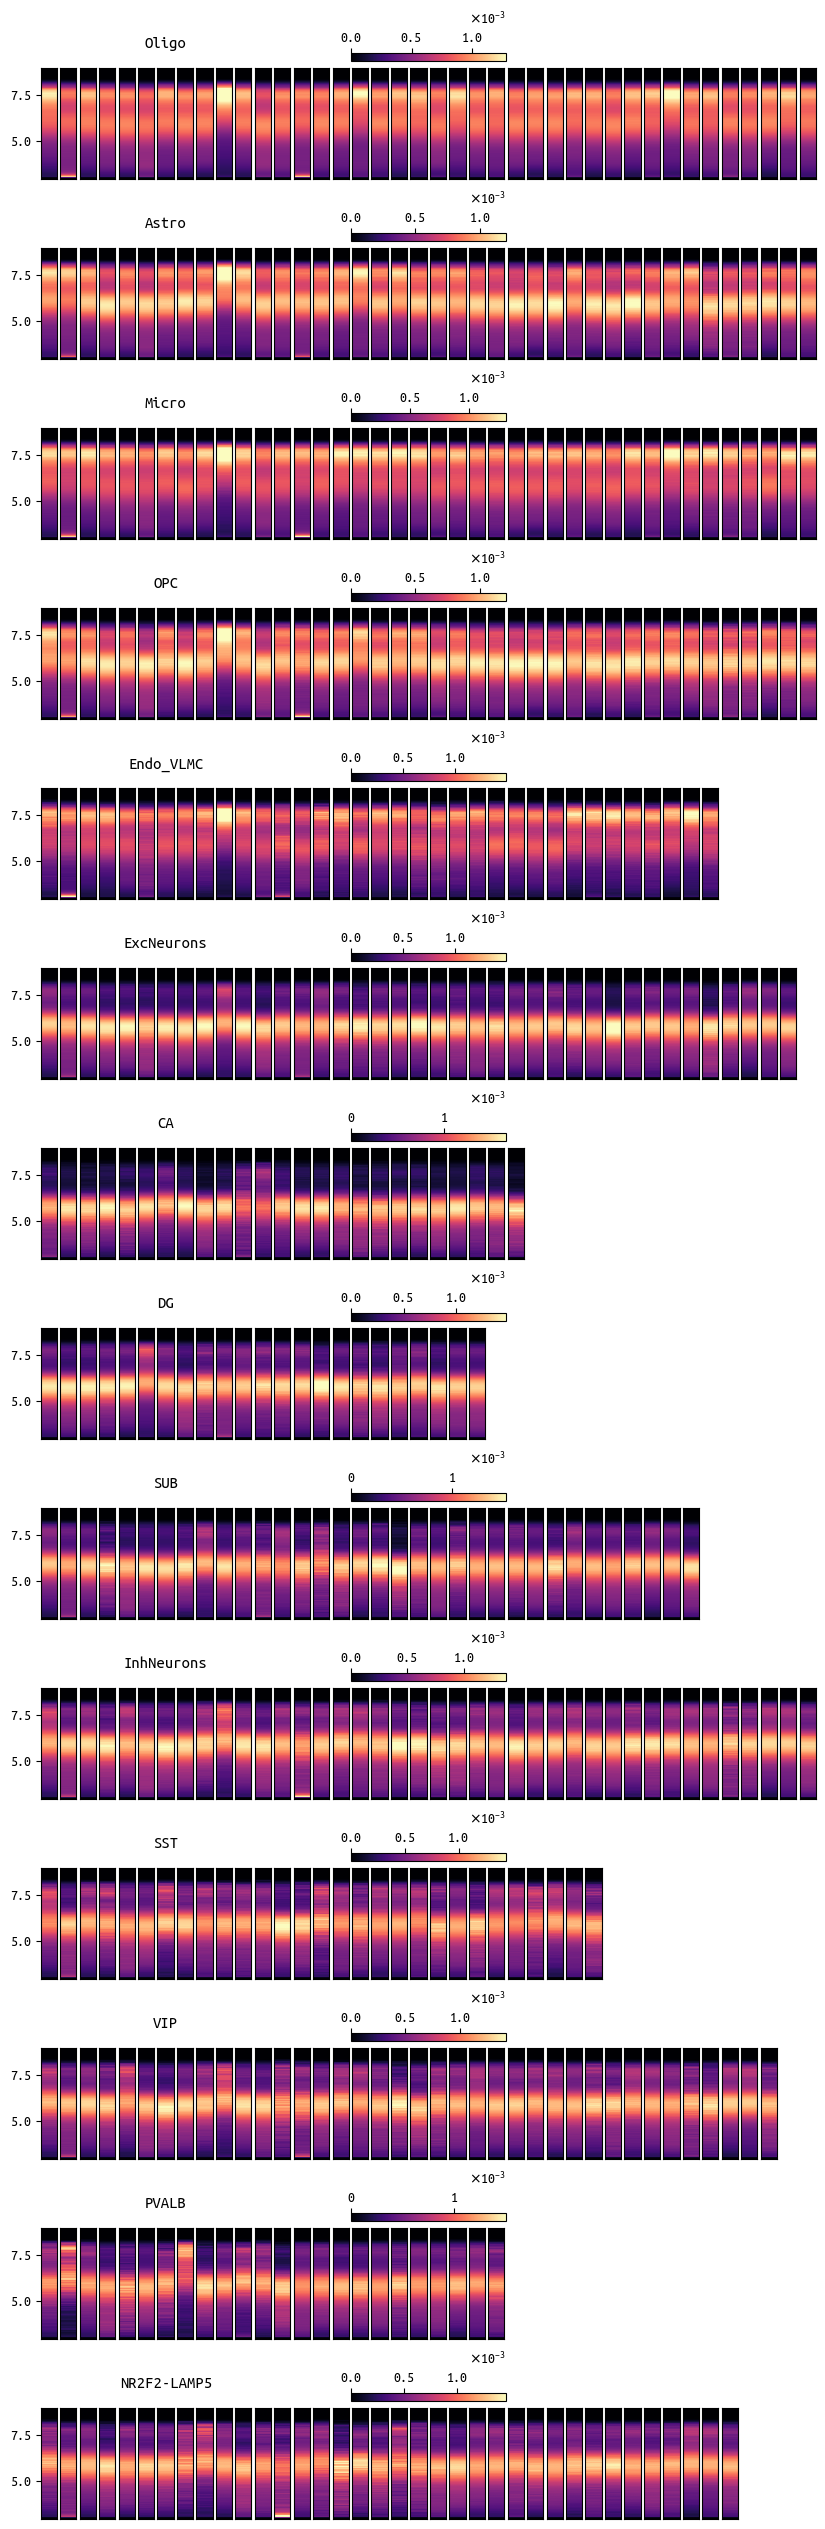

In [10]:
plt.rcParams["font.family"] = "Ubuntu Mono"
fig = plt.figure()
fig.set_figheight(len(clusters) * 1.8)
fig.set_figwidth(10)
sfigures = fig.subfigures(len(clusters), 1)

for i, cluster in enumerate(clusters):
    curr_donor_by_age = f"{cluster}-" + donor_by_age
    curr_df = percent_df.loc[:, curr_donor_by_age[curr_donor_by_age.isin(frequency_df.columns)]]

    curr_axs = sfigures[i].subplots(1, 40)
    for ax in curr_axs:
        ax.axis("off")
    for j, column in enumerate(curr_df.columns):
        curr_axs[j].axis("on")
        if j > 0:
            curr_axs[j].set_yticks([], [])
        # curr_axs[j].set_xticks([0.25], [column.split("-")[1]], rotation=45.0, fontsize=7.5, ha="right")
        curr_axs[j].set_xticks([], [])
        im = curr_axs[j].imshow(
            curr_df[column].to_numpy()[:, np.newaxis], 
            extent=[0, 0.5, common_bins.min(), common_bins.max()],
            origin="lower",
            aspect="auto",
            cmap="magma",
            vmin=0,
            vmax=np.quantile(curr_df, 0.995)
        )
    cbformat = ticker.ScalarFormatter()
    cbformat.set_scientific('%.2e')
    cbformat.set_powerlimits((-1,3))
    cbformat.set_useMathText(True)
    sfigures[i].colorbar(im, ax=curr_axs, location="top", shrink=0.2, format=cbformat)
    sfigures[i].suptitle(cluster, x=0.25, y=0.9)

In [11]:
from matplotlib import colormaps

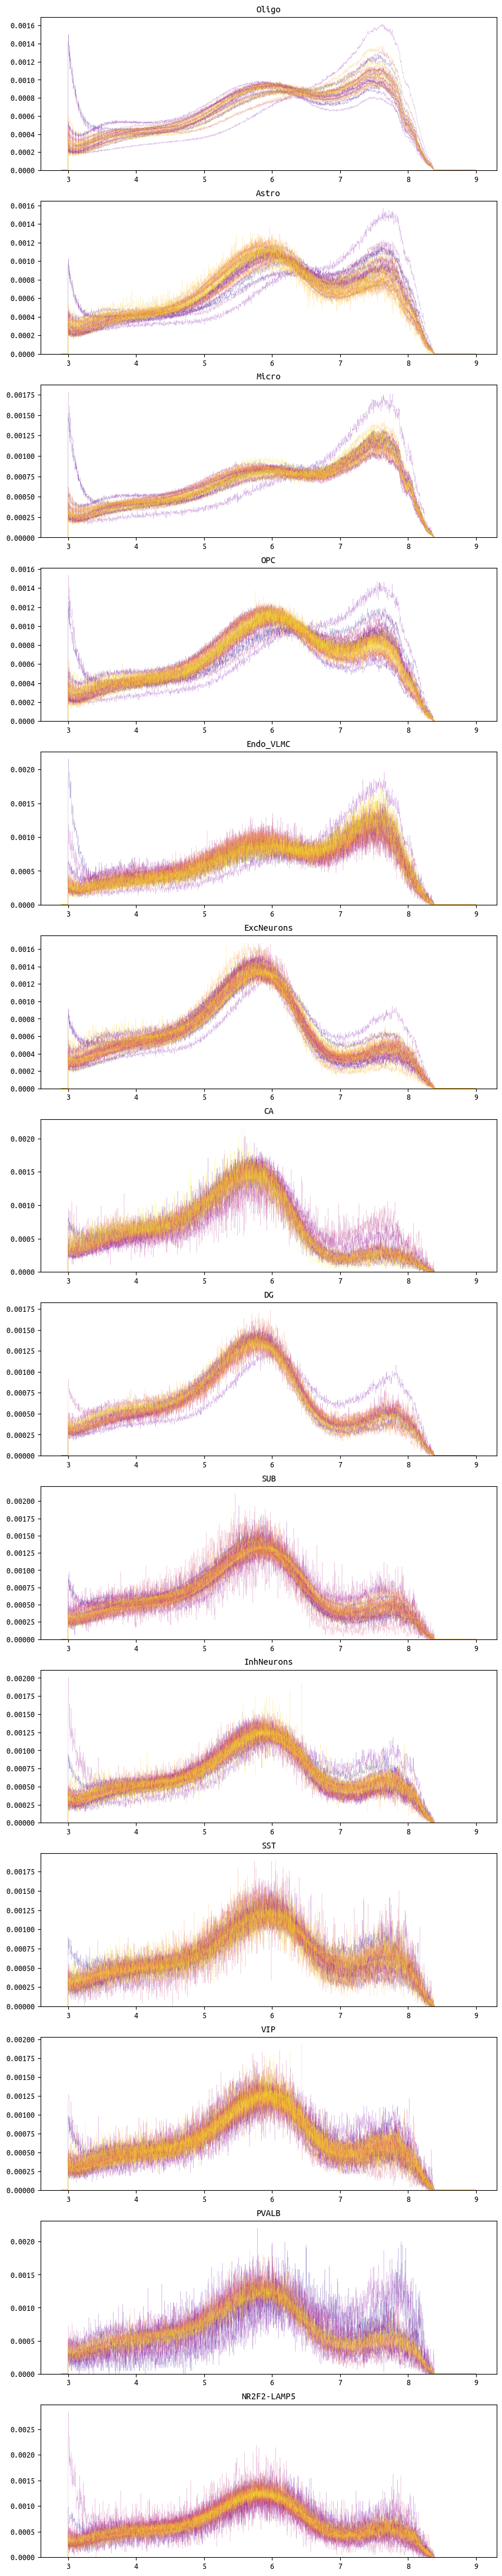

In [21]:
plt.rcParams["font.family"] = "Ubuntu Mono"
fig = plt.figure()
fig.set_figheight(len(clusters) * 4)
fig.set_figwidth(10)
axs = fig.subplots(len(clusters), 1)

for i, cluster in enumerate(clusters):
    curr_donor_by_age = f"{cluster}-" + donor_by_age
    curr_df = percent_df.loc[:, curr_donor_by_age[curr_donor_by_age.isin(frequency_df.columns)]]
    
    curr_cmap = colormaps["plasma"]
    colors = curr_cmap(np.linspace(0, 1, curr_df.shape[1]))

    for j, column in enumerate(curr_df.columns):
        # print(column)
        axs[i].stairs(
            curr_df[column],
            common_bins,
            color=colors[j],
            linewidth=0.1,
            label=column
        )
        # axs[i].legend()
        axs[i].set_title(cluster)

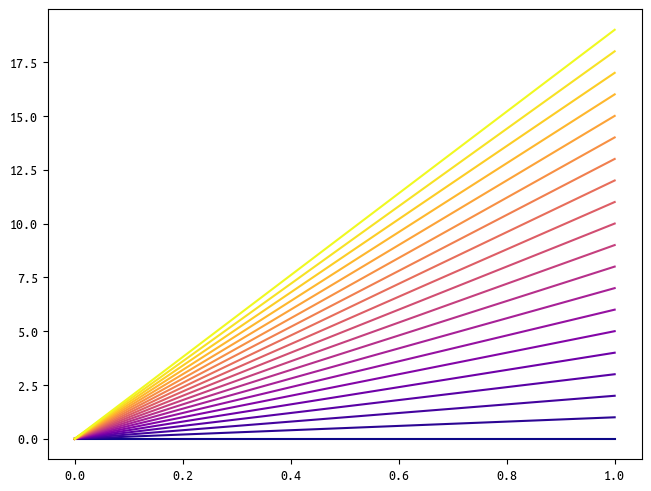

In [19]:
n_lines = 20
cmap = colormaps['plasma']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

fig, ax = plt.subplots(layout='constrained')

for i, color in enumerate(colors):
    ax.plot([0, i], color=color)

plt.show()

In [22]:
donor_by_age

0         hc78
1        M5276
2        m5579
3         hc76
4        m6052
5         hc29
6        m5614
7      pb13344
8         m935
9         m937
10       m1134
11     PB13414
12       m5021
13       m5087
14       m1745
15       m4781
16        hc81
17       m5610
18       m5551
19       s6021
20     pb13394
21     ms73787
22     hs46426
23         hc8
24       k1265
25      hc1271
26       k1203
27     ms69984
28      hc1153
29       k1216
30        hc98
31        hc12
32        hc11
33        hc73
34        hc19
35        hc26
36        hc40
37    ms212191
38        hc35
39         hc9
Name: donor, dtype: object

In [26]:
meta_df.groupby(["donor", "age"]).size()

donor     age
M5276     22     668
PB13414   41     581
hc11      86     574
hc1153    75     612
hc12      83     505
hc1271    71     613
hc19      87     559
hc26      91     554
hc29      28     573
hc35      94     482
hc40      91     633
hc73      86     567
hc76      26     706
hc78      20     382
hc8       69     488
hc81      48     562
hc9       95     513
hc98      82     521
hs46426   68     635
k1203     75     574
k1216     79     690
k1265     69     564
m1134     41     521
m1745     46     595
m4781     46     565
m5021     43     424
m5087     44     567
m5551     54     568
m5579     25     531
m5610     50     476
m5614     31     296
m6052     28     595
m935      38     518
m937      38     615
ms212191  92     532
ms69984   75     717
ms73787   66     616
pb13344   33     669
pb13394   65     573
s6021     55     306
dtype: int64

In [27]:
curr_df.columns

Index(['NR2F2-LAMP5-hc78', 'NR2F2-LAMP5-M5276', 'NR2F2-LAMP5-m5579',
       'NR2F2-LAMP5-hc76', 'NR2F2-LAMP5-m6052', 'NR2F2-LAMP5-m5614',
       'NR2F2-LAMP5-pb13344', 'NR2F2-LAMP5-m935', 'NR2F2-LAMP5-m937',
       'NR2F2-LAMP5-m1134', 'NR2F2-LAMP5-PB13414', 'NR2F2-LAMP5-m5021',
       'NR2F2-LAMP5-m5087', 'NR2F2-LAMP5-m1745', 'NR2F2-LAMP5-hc81',
       'NR2F2-LAMP5-m5610', 'NR2F2-LAMP5-s6021', 'NR2F2-LAMP5-pb13394',
       'NR2F2-LAMP5-ms73787', 'NR2F2-LAMP5-hs46426', 'NR2F2-LAMP5-hc8',
       'NR2F2-LAMP5-k1265', 'NR2F2-LAMP5-hc1271', 'NR2F2-LAMP5-k1203',
       'NR2F2-LAMP5-ms69984', 'NR2F2-LAMP5-hc1153', 'NR2F2-LAMP5-k1216',
       'NR2F2-LAMP5-hc98', 'NR2F2-LAMP5-hc12', 'NR2F2-LAMP5-hc11',
       'NR2F2-LAMP5-hc73', 'NR2F2-LAMP5-hc19', 'NR2F2-LAMP5-hc40',
       'NR2F2-LAMP5-ms212191', 'NR2F2-LAMP5-hc35', 'NR2F2-LAMP5-hc9'],
      dtype='object')

## Age group

In [3]:
import matplotlib.gridspec as gridspec

In [4]:
# Load meta file
meta_file = "/tscc/projects/ps-renlab2/sel041/scmethylhic/human_hippocampus/concat/human_aging_final_metadata.csv.gz"
meta_df = pd.read_csv(meta_file, header=0, index_col=1)
meta_df.drop(meta_df.columns[0], axis=1, inplace=True)

In [5]:
common_bins = np.arange(2.9, 9, 0.0035)
len(common_bins)

1743

In [6]:
frequency_df = pd.read_csv(hic_path / "contact_distance_freq_table.csv", sep=",", header=0, index_col=None)
percent_df = frequency_df / frequency_df.sum(axis=0)

In [7]:
meta_df.group.unique()

array(['60-80', '80-100', '20-40', '40-60'], dtype=object)

In [8]:
clusters = [
    "Oligo", "Astro", "Micro", "OPC", "Endo_VLMC", 
    "ExcNeurons", "CA", "DG", "SUB", 
    "InhNeurons", "SST", "VIP", "PVALB" ,"NR2F2-LAMP5"
]

In [9]:
# Y1: 2040, Y2: 4060, O1: 6080, O2: 80100
age_group_donors = meta_df.groupby("group", as_index=False).value_counts(["donor"])
age_group_Y1_donors = age_group_donors[age_group_donors["group"] == "20-40"]["donor"]
age_group_Y2_donors = age_group_donors[age_group_donors["group"] == "40-60"]["donor"]
age_group_O1_donors = age_group_donors[age_group_donors["group"] == "60-80"]["donor"]
age_group_O2_donors = age_group_donors[age_group_donors["group"] == "80-100"]["donor"]

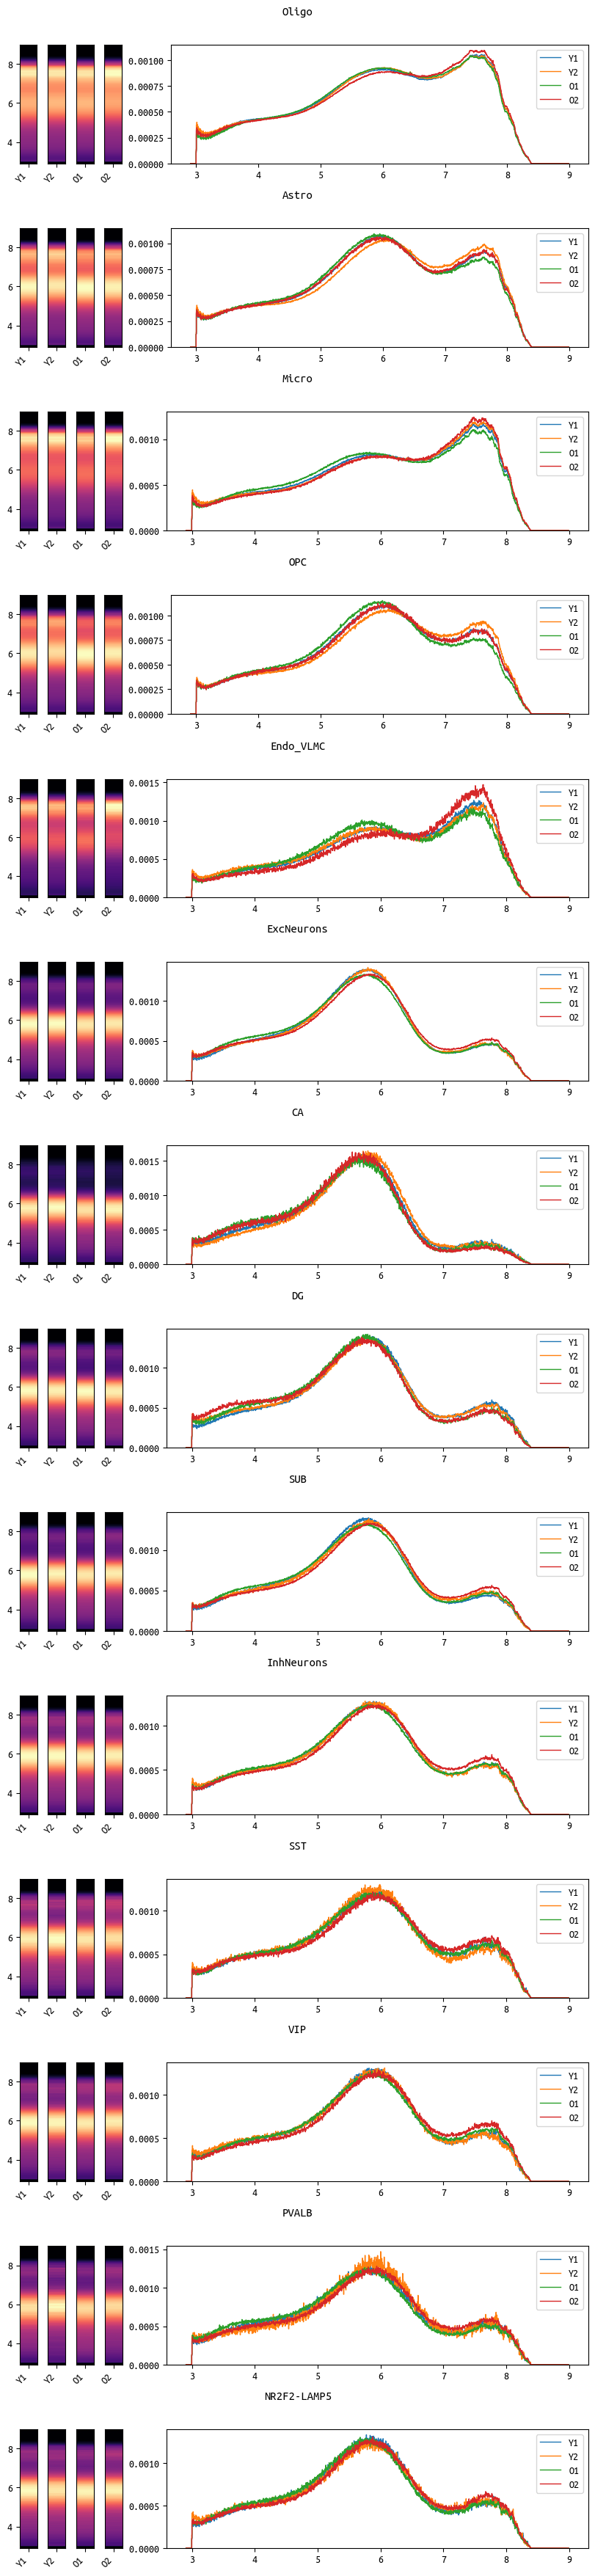

In [10]:
plt.rcParams["font.family"] = "Ubuntu Mono"
fig = plt.figure(layout="constrained")
fig.set_figwidth(8)
fig.set_figheight(len(clusters) * 2.5)
gs0 = gridspec.GridSpec(len(clusters), 1, figure=fig)

for i, cluster in enumerate(clusters):
    
    curr_df = frequency_df[[xx for xx in frequency_df.columns if xx.startswith(cluster)]].copy()
    curr_df.columns = [xx.split("-")[-1] for xx in curr_df.columns]
    
    curr_df["Y1"] = curr_df[curr_df.columns[curr_df.columns.isin(age_group_Y1_donors)]].sum(axis=1)
    curr_df["Y2"] = curr_df[curr_df.columns[curr_df.columns.isin(age_group_Y2_donors)]].sum(axis=1)
    curr_df["O1"] = curr_df[curr_df.columns[curr_df.columns.isin(age_group_O1_donors)]].sum(axis=1)
    curr_df["O2"] = curr_df[curr_df.columns[curr_df.columns.isin(age_group_O2_donors)]].sum(axis=1)

    curr_df = curr_df[["Y1", "Y2", "O1", "O2"]]
    curr_df = curr_df / curr_df.sum(axis=0)

    title_gs, data_gs = gridspec.GridSpecFromSubplotSpec(2, 1, height_ratios=[1, 19], subplot_spec=gs0[i])
    curr_gs = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1, 1, 1, 1, 24], subplot_spec=data_gs)
    
    # heatmaps
    for j, column in enumerate(curr_df.columns):
        ax = fig.add_subplot(curr_gs[j])
        if j > 0:
            ax.set_yticks([], [])
        ax.set_xticks([0.25], [column], rotation=45.0, fontsize=10, ha="right")
        # ax.set_xticks([], [])
        im = ax.imshow(
            curr_df[column].to_numpy()[:, np.newaxis], 
            extent=[0, 0.5, common_bins.min(), common_bins.max()],
            origin="lower",
            aspect="auto",
            cmap="magma",
            vmin=0,
            vmax=np.quantile(curr_df, 0.995)
        )

    ax = fig.add_subplot(curr_gs[4])
    for j, column in enumerate(curr_df.columns):
        ax.stairs(curr_df[column], common_bins, label=column)
    ax.legend()

    title_ax = fig.add_subplot(title_gs)
    title_ax.axis("off")
    title_ax.set_title(cluster, loc="center")

## A few quantities for checking distributions of contact distances

In [3]:
def count_quantities(contact_table_path):

    curr_contact_table = pd.read_csv(
        contact_table_path,
        names=["barcode", "path"],
        sep="\t",
        index_col=0
    )

    curr_contact_df_list = []
    for curr_contact_path in curr_contact_table["path"]:
        curr_contact_df = pd.read_csv(
            curr_contact_path, 
            header=None, 
            index_col=None, 
            sep="\t",
            names=["frag1", "chr1", "pos1", "strand1", "frag2", "chr2", "pos2", "strand2"]
        )
        curr_contact_df_list.append(curr_contact_df)
    final_contact_df = pd.concat(curr_contact_df_list, axis=0)

    final_contact_df_cis = final_contact_df[final_contact_df["chr1"] == final_contact_df["chr2"]]
    final_contact_df_cis = final_contact_df_cis.assign(distance=lambda x: abs(x.pos1 - x.pos2))

    n_trans = final_contact_df.shape[0] - final_contact_df_cis.shape[0]
    n_lt_10m = final_contact_df_cis[final_contact_df_cis.distance < 1e7].shape[0]
    n_gt_10m = final_contact_df_cis[final_contact_df_cis.distance > 1e7].shape[0]

    print("Finished {}...".format(contact_table_path.stem))
    print("Result:")
    print("Total: {}".format(final_contact_df.shape[0]))
    print("# Trans: {}".format(n_trans))
    print("# Cis shorter than 1e7: {}".format(n_lt_10m))
    print("# Cis longer than 1e7: {}".format(n_gt_10m))

    return (n_trans, n_lt_10m, n_gt_10m)

In [4]:
all_names = []
for file in contact_table_path.glob("*/*tsv"):
    all_names.append(file.stem)
result_df = pd.DataFrame(
    {
        "n_trans": np.repeat(0, len(all_names)),
        "n_cis_lt_10M": np.repeat(0, len(all_names)),
        "n_cis_gt_10M": np.repeat(0, len(all_names))
    },
    index=all_names
)

In [5]:
for file in contact_table_path.glob("*/*tsv"):
    result_df.loc[file.stem] = count_quantities(file)

Finished NR2F2-LAMP5-PB13414...
Result:
Total: 279536
# Trans: 75125
# Cis shorter than 1e7: 181673
# Cis longer than 1e7: 22738
Finished NR2F2-LAMP5-pb13344...
Result:
Total: 395894
# Trans: 143246
# Cis shorter than 1e7: 215003
# Cis longer than 1e7: 37645
Finished NR2F2-LAMP5-m1745...
Result:
Total: 704086
# Trans: 246146
# Cis shorter than 1e7: 376649
# Cis longer than 1e7: 81291
Finished NR2F2-LAMP5-hc1271...
Result:
Total: 1070988
# Trans: 449934
# Cis shorter than 1e7: 509152
# Cis longer than 1e7: 111902
Finished NR2F2-LAMP5-hc1153...
Result:
Total: 202891
# Trans: 77055
# Cis shorter than 1e7: 104109
# Cis longer than 1e7: 21727
Finished NR2F2-LAMP5-hc76...
Result:
Total: 447746
# Trans: 138354
# Cis shorter than 1e7: 278200
# Cis longer than 1e7: 31192
Finished NR2F2-LAMP5-pb13394...
Result:
Total: 135867
# Trans: 52742
# Cis shorter than 1e7: 71151
# Cis longer than 1e7: 11974
Finished NR2F2-LAMP5-ms69984...
Result:
Total: 186347
# Trans: 72610
# Cis shorter than 1e7: 94475


In [9]:
result_df.index.set_names(["barcode"])
result_df.to_csv(hic_path / "contact_distance_trans_cis.tsv", sep="\t", header=True, index=True, index_label="barcode")

## Plot the result

In [3]:
result_df = pd.read_csv(
    hic_path / "contact_distance_trans_cis.tsv",
    index_col=0,
    header=0,
    sep="\t"
)

In [4]:
result_df["total"] = result_df.n_trans + result_df.n_cis_lt_10M + result_df.n_cis_gt_10M
result_df["trans_ratio"] = result_df["n_trans"] / result_df["total"]
result_df["n_cis"] = result_df.n_cis_lt_10M + result_df.n_cis_gt_10M
result_df["long_range_ratio"] = result_df.n_cis_gt_10M / result_df.n_cis

In [5]:
result_df["subclass"] = [xx.rsplit("-", 1)[0] for xx in result_df.index]
result_df["donor"] = [xx.rsplit("-", 1)[1] for xx in result_df.index]

In [6]:
# Load meta file
meta_file = "/tscc/projects/ps-renlab2/sel041/scmethylhic/human_hippocampus/concat/human_aging_final_metadata.csv.gz"
meta_df = pd.read_csv(meta_file, header=0, index_col=1)
meta_df.drop(meta_df.columns[0], axis=1, inplace=True)

In [7]:
# Get the age of each donor and sort by age
donor_by_age = (
    meta_df.groupby(["donor", "age"])
        .size().reset_index().rename(columns={0:"count"})
        .sort_values(by=["age"], axis=0).donor
).reset_index(drop=True)

In [8]:
subclass_order = [
    "Oligo", "Astro", "Micro", "Endo_VLMC", "OPC",
    "ExcNeurons", "CA", "DG", "SUB",
    "InhNeurons", "NR2F2-LAMP5", "PVALB", "VIP", "SST"
]

In [9]:
age_group_donors = meta_df.groupby("group", as_index=False).value_counts(["donor"])
donor_age = {xx: yy for xx, yy in zip(age_group_donors.donor, age_group_donors.group)}
result_df["age_group"] = [donor_age[xx] for xx in result_df.donor]
result_df["subclass_age_group"] = ["-".join([xx, yy]) for xx, yy in zip(result_df.subclass, result_df.age_group)]

In [10]:
index_order = pd.Index(["-".join([xx, yy]) for xx in subclass_order for yy in donor_by_age])

In [11]:
result_df_sorted = result_df.loc[index_order[index_order.isin(result_df.index)]]

In [12]:
import seaborn as sns

In [14]:
age_colors = {
    "20-40": "#1B9E77",
    "40-60": "#CCCD66",
    "60-80": "#7570B3",
    "80-100": "#E7298A"
}

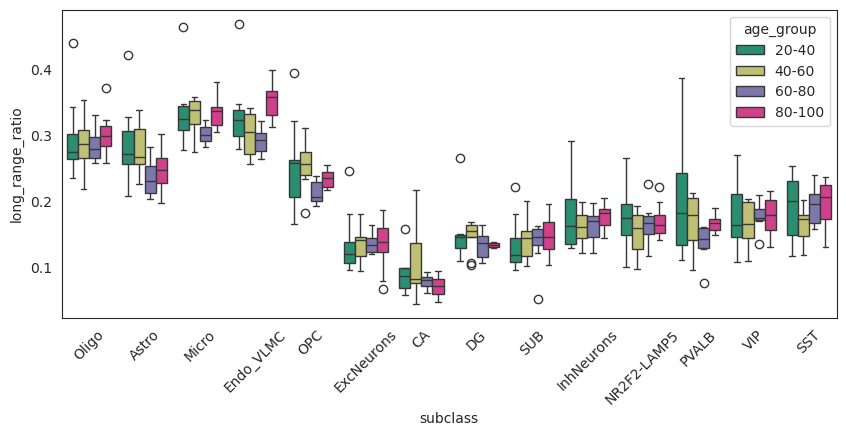

In [17]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(10)
fig.set_figheight(4)
sns.set_style("white")
sns.boxplot(
    data=result_df_sorted.reset_index(),
    x="subclass",
    y="long_range_ratio",
    hue="age_group",
    ax=ax,
    palette=age_colors,
    legend=True
)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45);
fig.savefig(
    "/tscc/projects/ps-epigen/users/biy022/MGH/reports/20240328_grant_application/donor_long_range_ratio.pdf",
    format="pdf",
    bbox_inches="tight"
)

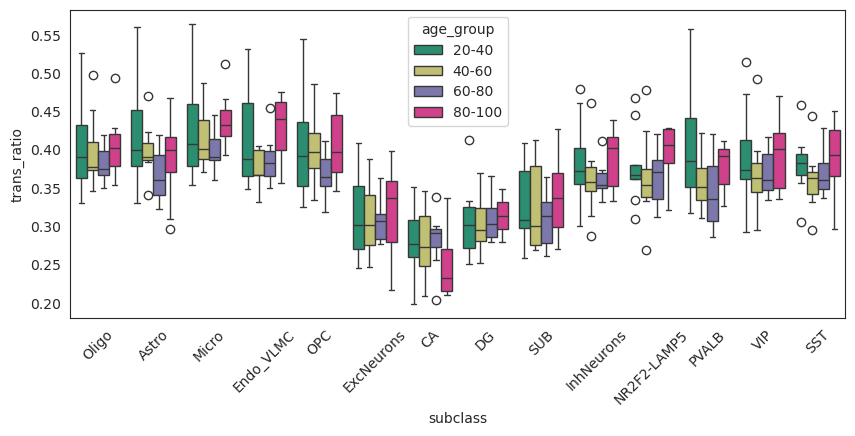

In [18]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(10)
fig.set_figheight(4)
sns.set_style("white")
sns.boxplot(
    data=result_df_sorted.reset_index(),
    x="subclass",
    y="trans_ratio",
    hue="age_group",
    ax=ax,
    palette=age_colors,
    legend=True
)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45);
fig.savefig(
    "/tscc/projects/ps-epigen/users/biy022/MGH/reports/20240328_grant_application/donor_trans_ratio.pdf",
    format="pdf",
    bbox_inches="tight"
)

In [16]:
result_df_sorted.to_csv(hic_path / "contact_distance_trans_cis.tsv", sep="\t", header=True, index=True, index_label="barcode")

In [18]:
result_df_sorted.columns

Index(['n_trans', 'n_cis_lt_10M', 'n_cis_gt_10M', 'total', 'trans_ratio',
       'n_cis', 'long_range_ratio', 'subclass', 'donor', 'age_group',
       'subclass_age_group'],
      dtype='object')

In [29]:
result_df_age_group_only = result_df_sorted[[
    "total", "n_trans", "n_cis", "n_cis_lt_10M", "n_cis_gt_10M", "subclass", "age_group"]]
result_df_age_group_only = result_df_age_group_only.groupby(["subclass", "age_group"], sort=False).agg(
    {
        "total": "sum",
        "n_trans": "sum",
        "n_cis": "sum",
        "n_cis_lt_10M": "sum",
        "n_cis_gt_10M": "sum"
    }
)
result_df_age_group_only.reset_index(inplace=True)

In [30]:
result_df_age_group_only["trans_ratio"] = result_df_age_group_only.n_trans / result_df_age_group_only.total
result_df_age_group_only["long_range_ratio"] = result_df_age_group_only.n_cis_gt_10M / result_df_age_group_only.n_cis

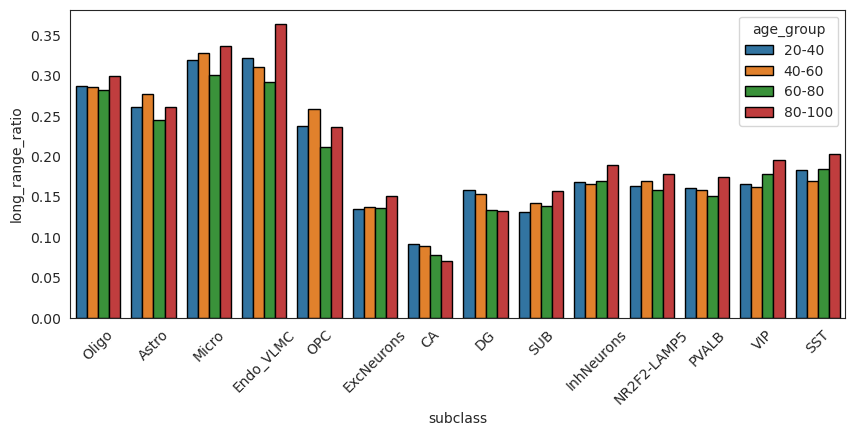

In [32]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(10)
fig.set_figheight(4)
sns.set_style("white")
sns.barplot(
    data=result_df_age_group_only,
    x="subclass",
    y="long_range_ratio",
    hue="age_group",
    ax=ax,
    legend=True,
    ec="black"
)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45);

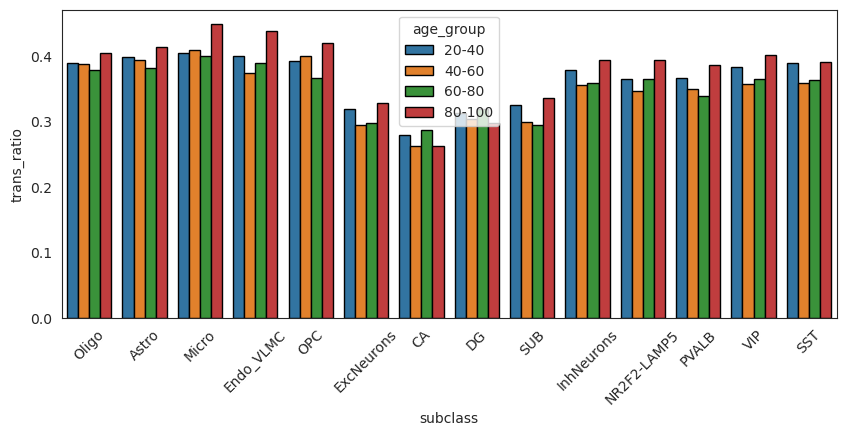

In [33]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(10)
fig.set_figheight(4)
sns.set_style("white")
sns.barplot(
    data=result_df_age_group_only,
    x="subclass",
    y="trans_ratio",
    hue="age_group",
    ax=ax,
    legend=True,
    ec="black"
)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45);

In [34]:
result_df_age_group_only[result_df_age_group_only.subclass == "Oligo"]

,subclass,age_group,total,n_trans,n_cis,n_cis_lt_10M,n_cis_gt_10M,trans_ratio,long_range_ratio
0,Oligo,20-40,392252376,152566743,239685633,170749932,68935701,0.388950,0.287609
1,Oligo,40-60,480723786,186084632,294639154,210491534,84147620,0.387093,0.285596
2,Oligo,60-80,552135276,208793889,343341387,246307342,97034045,0.378157,0.282617
3,Oligo,80-100,253689694,102541966,151147728,105816173,45331555,0.404202,0.299916


## Plot result based on mapping summary

In [4]:
import seaborn as sns

In [5]:
result_df = pd.read_csv(
    hic_path / "contact_distance_trans_cis.tsv",
    index_col=0,
    header=0,
    sep="\t"
)

In [6]:
result_df = result_df[["subclass", "donor", "age_group", "n_cis_lt_10M", "n_cis_gt_10M", "n_trans"]]

In [7]:
result_df.shape

(483, 6)

In [8]:
# Load meta file
meta_file = "/tscc/projects/ps-renlab2/sel041/scmethylhic/human_hippocampus/concat/human_aging_final_metadata.csv.gz"
meta_df = pd.read_csv(meta_file, header=0, index_col=1)
meta_df.drop(meta_df.columns[0], axis=1, inplace=True)

In [9]:
meta_subdf_1 = meta_df[[
    "TransContact", "CisLongContact", "CisShortContact", "TotalContacts", 
    "donor", "final_celltype"
]]

In [10]:
meta_subdf_1.loc[:, "label"] = meta_subdf_1.apply(lambda row: "-".join([row.final_celltype, row.donor]), axis=1)

In [11]:
meta_subdf_1 = meta_subdf_1.groupby("label").agg(
    TransContact=("TransContact", "sum"),
    CisLongContact=("CisLongContact", "sum"),
    CisShortContact=("CisShortContact", "sum"),
    TotalContacts=("TotalContacts", "sum"),
    donor=("donor", "first"),
    subclass=("final_celltype", "first")
)

In [12]:
meta_subdf_2 = meta_df[[
    "TransContact", "CisLongContact", "CisShortContact", "TotalContacts", 
    "donor", "final_celltype2"
]]
meta_subdf_2 = meta_subdf_2[meta_subdf_2.final_celltype2.isin(["ExcNeurons", "InhNeurons"])]

In [13]:
meta_subdf_2.loc[:, "label"] = meta_subdf_2.apply(lambda row: "-".join([row.final_celltype2, row.donor]), axis=1)

In [14]:
meta_subdf_2 = meta_subdf_2.groupby("label").agg(
    TransContact=("TransContact", "sum"),
    CisLongContact=("CisLongContact", "sum"),
    CisShortContact=("CisShortContact", "sum"),
    TotalContacts=("TotalContacts", "sum"),
    donor=("donor", "first"),
    subclass=("final_celltype2", "first")
)

In [15]:
mapping_summary_df = pd.concat([meta_subdf_1, meta_subdf_2], axis=0)

In [16]:
del mapping_summary_df["donor"]
del mapping_summary_df["subclass"]

In [17]:
final_df = pd.concat([result_df, mapping_summary_df], axis=1)

In [18]:
final_df["trans_ratio"] = final_df.TransContact / final_df.TotalContacts

In [19]:
age_colors = {
    "20-40": "#1B9E77",
    "40-60": "#CCCD66",
    "60-80": "#7570B3",
    "80-100": "#E7298A"
}

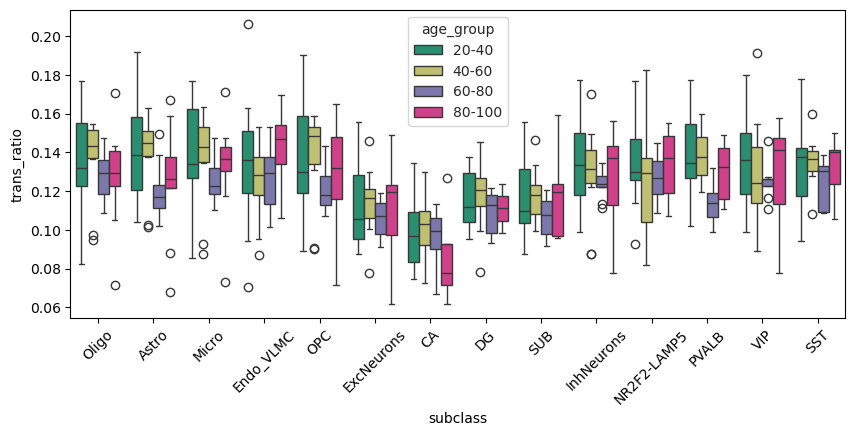

In [20]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(10)
fig.set_figheight(4)
sns.set_style("white")
sns.boxplot(
    data=final_df.reset_index(),
    x="subclass",
    y="trans_ratio",
    hue="age_group",
    ax=ax,
    palette=age_colors,
    legend=True
)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45);

In [21]:
final_df["long_cis_ratio"] = final_df.n_cis_gt_10M / (final_df.CisLongContact + final_df.CisShortContact)

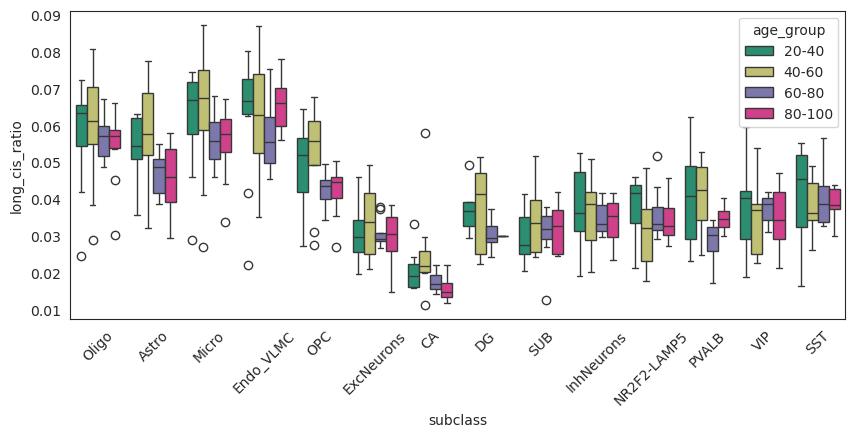

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(10)
fig.set_figheight(4)
sns.set_style("white")
sns.boxplot(
    data=final_df.reset_index(),
    x="subclass",
    y="long_cis_ratio",
    hue="age_group",
    ax=ax,
    palette=age_colors,
    legend=True
)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45);

## Plot trans ratios for microglia subtypes

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import anndata
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from scipy.stats import mannwhitneyu

In [2]:
# Load meta file
meta_file = "/tscc/projects/ps-renlab2/sel041/scmethylhic/human_hippocampus/concat/human_aging_final_metadata.csv.gz"
meta_df = pd.read_csv(meta_file, header=0, index_col=1)
meta_df.drop(meta_df.columns[0], axis=1, inplace=True)

In [3]:
micro_subtypes_df = meta_df.loc[meta_df["final_cluster"].isin(["Micro1", "Micro2"]), :]

In [4]:
micro_subtypes_df = micro_subtypes_df[[
    "TransContact", "CisLongContact", "CisShortContact", "TotalContacts", 
    "donor", "final_cluster"
]]

In [5]:
micro_subtypes_df["TransRatio"] = micro_subtypes_df["TransContact"] / \
    micro_subtypes_df["TotalContacts"]

In [6]:
subtype_colors = {
    "Micro1": "#87B9DD",
    "Micro2": "#777ED8",
}

In [7]:
# figure save directory
figure_dir = Path("/tscc/projects/ps-epigen/users/biy022/scmethylhic/human_hippocampus/snm3c/Combined/hic/figures/")

In [8]:
micro_subtypes_df["final_cluster"] = pd.Categorical(
    micro_subtypes_df["final_cluster"], categories=["Micro1", "Micro2"])

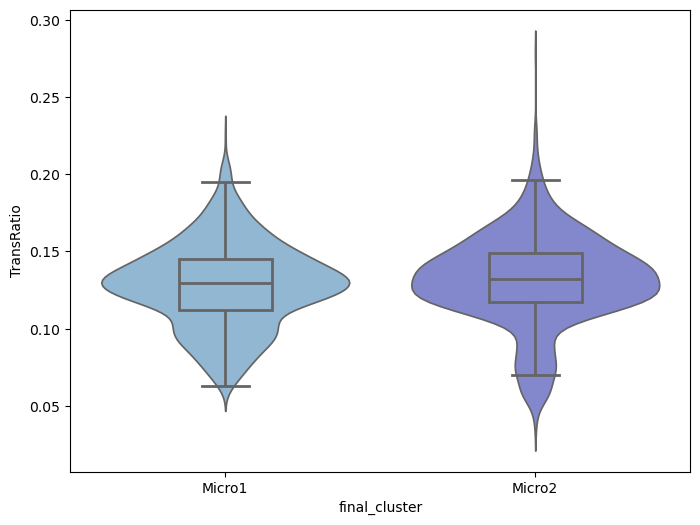

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)

sns.violinplot(
    data=micro_subtypes_df, x="final_cluster", y="TransRatio", hue="final_cluster",
    ax=ax, palette=subtype_colors, inner=None
)
sns.boxplot(
    data=micro_subtypes_df, x="final_cluster", y="TransRatio", hue="final_cluster",
    ax=ax, width=0.3, palette=subtype_colors, boxprops={"zorder": 2},
    showfliers=False, linewidth=2
)
fig.savefig(
    str(figure_dir / (f"MicroSubtypes_TransRatio" + ".pdf")),
    dpi=300,
    format="pdf"
)

In [10]:
stat, p_value = mannwhitneyu(
    micro_subtypes_df.loc[micro_subtypes_df["final_cluster"] == "Micro1", "TransRatio"],
    micro_subtypes_df.loc[micro_subtypes_df["final_cluster"] == "Micro2", "TransRatio"]
)

In [11]:
p_value

0.0008256878662703733

In [12]:
micro_subtypes_df = meta_df.loc[meta_df["final_cluster"].isin(["Micro1", "Micro2"]), :]

In [13]:
micro_subtypes_df = micro_subtypes_df[[
    "TransContact", "CisLongContact", "CisShortContact", "TotalContacts", 
    "donor", "final_cluster"
]]

In [17]:
micro_subtypes_df["TransRatio"] = micro_subtypes_df["TransContact"] / \
    (micro_subtypes_df["CisLongContact"] + micro_subtypes_df["TransContact"])

In [18]:
micro_subtypes_df["final_cluster"] = pd.Categorical(
    micro_subtypes_df["final_cluster"], categories=["Micro1", "Micro2"])

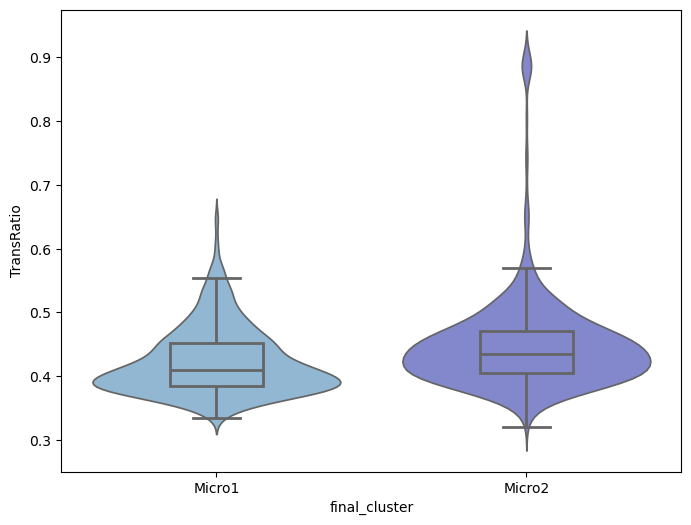

In [19]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)

sns.violinplot(
    data=micro_subtypes_df, x="final_cluster", y="TransRatio", hue="final_cluster",
    ax=ax, palette=subtype_colors, inner=None
)
sns.boxplot(
    data=micro_subtypes_df, x="final_cluster", y="TransRatio", hue="final_cluster",
    ax=ax, width=0.3, palette=subtype_colors, boxprops={"zorder": 2},
    showfliers=False, linewidth=2
)
fig.savefig(
    str(figure_dir / (f"MicroSubtypes_TransRatio_NoCisShort" + ".pdf")),
    dpi=300,
    format="pdf"
)

In [20]:
stat, p_value = mannwhitneyu(
    micro_subtypes_df.loc[micro_subtypes_df["final_cluster"] == "Micro1", "TransRatio"],
    micro_subtypes_df.loc[micro_subtypes_df["final_cluster"] == "Micro2", "TransRatio"]
)

In [21]:
p_value

1.411442895391619e-30

In [22]:
micro_subtypes_df.shape

(2604, 7)